# Level 1: Data Loading, Cleaning, and EDA

This section performs initial data loading and preprocessing.
It also includes basic visualizations for understanding the distribution of crime data.


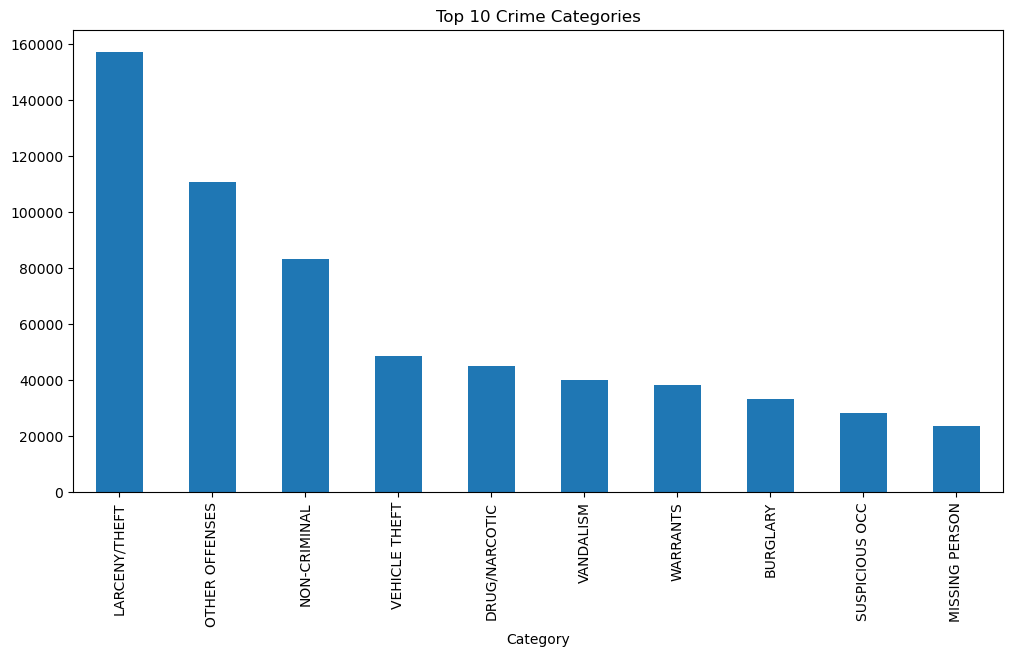

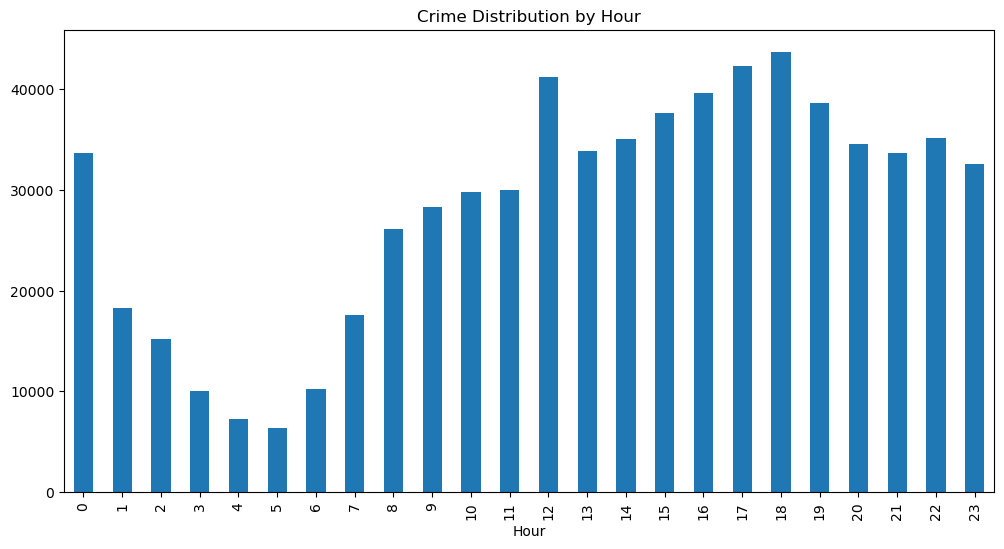

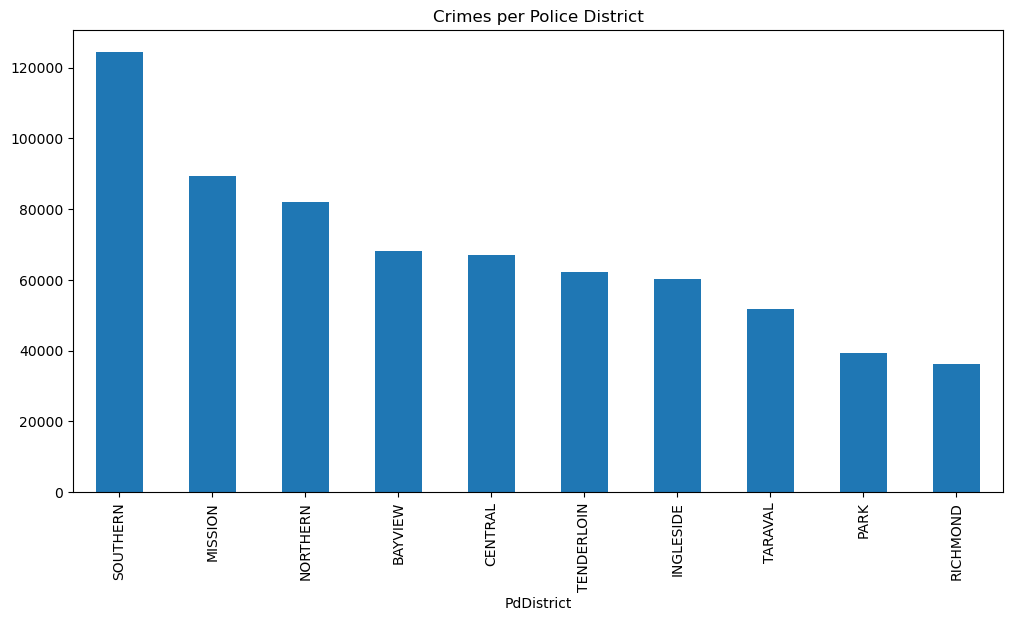

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the raw crime dataset from the CSV file
df = pd.read_csv("Competition_Dataset.csv")

# ----- Data Cleaning -----

# Convert datetime
df['Dates'] = pd.to_datetime(df['Dates'])
df['Hour'] = df['Dates'].dt.hour
df['Month'] = df['Dates'].dt.month
df['Year'] = df['Dates'].dt.year

# Fix the coordinate column names (they were reversed)
df = df.rename(columns={
    'Latitude (Y)': 'Longitude',
    'Longitude (X)': 'Latitude'
})

# ----- EDA Visualizations -----

# Plot the top 10 most frequent crime categories
plt.figure(figsize=(12,6))
df['Category'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Crime Categories')
plt.show()

# Plot the distribution of crimes by hour of the day
plt.figure(figsize=(12,6))
df['Hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Crime Distribution by Hour')
plt.show()

# Plot the number of crimes per police district
plt.figure(figsize=(12,6))
df['PdDistrict'].value_counts().plot(kind='bar')
plt.title('Crimes per Police District')
plt.show()

# Save the cleaned dataset to a new CSV file for future use
df.to_csv("processed_data.csv", index=False)

# Level 2A and 2B: Crime Category Prediction and Severity Mapping

This section builds and evaluates a machine learning model that classifies crimes based on their description,
then assigns each crime a severity level based on predefined rules.


In [94]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# ----- Part A: Crime Type Prediction -----

# Prepare the text feature (crime description) and the target label (crime category)
X = df['Descript']
y = df['Category']

# Split the dataset into training and testing sets (80% train, 20% test)
# Stratify ensures balanced class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create a machine learning pipeline:
# 1. TF-IDF vectorizer turns text into numerical features
# 2. Logistic Regression performs classification
model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train the model using the training data
model.fit(X_train, y_train)

# Predict the categories on the test data
y_pred = model.predict(X_test)

# Print evaluation metrics: precision, recall, F1-score
print(classification_report(y_test, y_pred))

# ----- Part B: Severity Mapping -----

# Map each crime category to a severity level (1 = low, 5 = high)
severity_map = {
    # Severity 1
    "NON-CRIMINAL": 1,
    "SUSPICIOUS OCCURRENCE": 1,
    "MISSING PERSON": 1,
    "RUNAWAY": 1,
    "RECOVERED VEHICLE": 1,
    
    # Severity 2
    "WARRANTS": 2,
    "OTHER OFFENSES": 2,
    "VANDALISM": 2,
    "TRESPASS": 2,
    "DISORDERLY CONDUCT": 2,
    "BAD CHECKS": 2,
    
    # Severity 3
    "LARCENY/THEFT": 3,
    "VEHICLE THEFT": 3,
    "FORGERY/COUNTERFEITING": 3,
    "DRUG/NARCOTIC": 3,
    "STOLEN PROPERTY": 3,
    "FRAUD": 3,
    "BRIBERY": 3,
    "EMBEZZLEMENT": 3,
    
    # Severity 4
    "ROBBERY": 4,
    "WEAPON LAWS": 4,
    "BURGLARY": 4,
    "EXTORTION": 4,
    
    # Severity 5
    "KIDNAPPING": 5,
    "ARSON": 5,
    
    # Categories not listed will be handled separately if needed
}

# Add a new column with severity values for each crime
df['Severity'] = df['Category'].map(severity_map)

# Create a copy of the original test set rows (to include original fields)
X_test_full = df.loc[X_test.index].copy()

# Add model predictions to the copied test set
X_test_full['Predicted_Category'] = y_pred

# Assign severity based on predicted category
X_test_full['Predicted_Severity'] = X_test_full['Predicted_Category'].map(severity_map)

# Save the final predictions to CSV for use in the dashboard
X_test_full.to_csv("predicted_data.csv", index=False)

                        precision    recall  f1-score   support

                 ARSON       1.00      1.00      1.00       278
            BAD CHECKS       1.00      1.00      1.00        73
               BRIBERY       1.00      0.96      0.98        51
              BURGLARY       1.00      1.00      1.00      6617
    DISORDERLY CONDUCT       1.00      1.00      1.00       780
         DRUG/NARCOTIC       1.00      1.00      1.00      8961
          EMBEZZLEMENT       1.00      1.00      1.00       207
             EXTORTION       1.00      1.00      1.00        45
FORGERY/COUNTERFEITING       1.00      1.00      1.00      1761
                 FRAUD       1.00      1.00      1.00      3008
            KIDNAPPING       1.00      1.00      1.00       418
         LARCENY/THEFT       1.00      1.00      1.00     31448
        MISSING PERSON       1.00      1.00      1.00      4668
          NON-CRIMINAL       1.00      1.00      1.00     16641
        OTHER OFFENSES       1.00      

# Level 4A: Batch Extraction from Police Report PDFs

This section extracts structured information (description, coordinates, date, etc.)
from a batch of PDF police reports using regular expressions and the PyMuPDF library.


In [86]:
import os
import fitz  # PyMuPDF
import re
import pandas as pd

# Define a function that extracts key crime details from a single PDF report
def extract_crime_info(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()

    # Use regular expressions to extract specific fields from the text
    date_time = re.search(r'Date & Time:\s+(.+)', text)
    description = re.search(r'Detailed Description:\s+(.+)', text)
    district = re.search(r'Police District:\s+(.+)', text)
    coordinates = re.search(r'Coordinates:\s+\(([-\d.]+),\s+([-\d.]+)\)', text)

    # Return the extracted information in dictionary format
    return {
        "Descript": description.group(1).strip() if description else "",
        "PdDistrict": district.group(1).strip() if district else "",
        "Latitude": float(coordinates.group(1)) if coordinates else None,
        "Longitude": float(coordinates.group(2)) if coordinates else None,
        "DateTime": date_time.group(1).strip() if date_time else "",
        "Filename": os.path.basename(pdf_path)
    }

# Set the path to the folder that contains all the police report PDFs
pdf_folder = "Police Reports"

# List all PDF files in the folder
pdf_files = [os.path.join(pdf_folder, f) for f in os.listdir(pdf_folder) if f.endswith(".pdf")]

# Apply the extraction function to each file and store the results
extracted_data = [extract_crime_info(pdf) for pdf in pdf_files]

# Convert the list of extracted dictionaries into a DataFrame
pdf_df = pd.DataFrame(extracted_data)

# Display the first few rows of the extracted data
pdf_df.head()


,Descript,PdDistrict,Latitude,Longitude,DateTime,Filename
0,Petty theft from locked auto. Personal belongi...,Southern,37.780917,-122.404100,2013-08-11 18:00:00,police_crime_report_1.pdf
1,Investigative detention. Officers detained a p...,Tenderloin,37.785492,-122.407854,2010-09-10 17:17:00,police_crime_report_3.pdf
2,Petty theft of property. Wallet and phone repo...,Central,37.807137,-122.406429,2010-10-04 12:15:00,police_crime_report_2.pdf
3,"Aided case, mentally disturbed individual. Sub...",Ingleside,37.712676,-122.415587,2014-09-06 19:00:00,police_crime_report_6.pdf
4,Evading a police officer recklessly. High-spee...,Bayview,37.729545,-122.386421,2010-12-29 08:39:00,police_crime_report_7.pdf


# Level 4B: Predict Category and Severity for PDF Reports

Using the trained model from earlier, this section predicts the crime category for each extracted description
and maps it to a severity level using the same severity rule set.


In [92]:
# ---- Use the model to predict category ----

# Apply the trained model to predict the crime category based on the extracted description
pdf_df['Predicted_Category'] = model.predict(pdf_df['Descript'])

# ---- Map predicted category to severity ----

# Define severity levels for each possible crime category
# The severity levels range from 1 (least severe) to 5 (most severe)
severity_map = {
    "NON-CRIMINAL": 1, "SUSPICIOUS OCCURRENCE": 1, "MISSING PERSON": 1,
    "RUNAWAY": 1, "RECOVERED VEHICLE": 1,
    "WARRANTS": 2, "OTHER OFFENSES": 2, "VANDALISM": 2, "TRESPASS": 2,
    "DISORDERLY CONDUCT": 2, "BAD CHECKS": 2,
    "LARCENY/THEFT": 3, "VEHICLE THEFT": 3, "FORGERY/COUNTERFEITING": 3,
    "DRUG/NARCOTIC": 3, "STOLEN PROPERTY": 3, "FRAUD": 3,
    "BRIBERY": 3, "EMBEZZLEMENT": 3,
    "ROBBERY": 4, "WEAPON LAWS": 4, "BURGLARY": 4, "EXTORTION": 4,
    "KIDNAPPING": 5, "ARSON": 5
}

# Assign severity to each predicted category
# If the category is not found in the mapping, assign 0 by default
pdf_df['Predicted_Severity'] = pdf_df['Predicted_Category'].map(severity_map).fillna(0)

# Display the relevant columns with filename, description, and predictions
pdf_df[[
    'Filename', 'Descript', 'PdDistrict',
    'Predicted_Category', 'Predicted_Severity'
]]

,Filename,Descript,PdDistrict,Predicted_Category,Predicted_Severity
0,police_crime_report_1.pdf,Petty theft from locked auto. Personal belongi...,Southern,LARCENY/THEFT,3.0
1,police_crime_report_3.pdf,Investigative detention. Officers detained a p...,Tenderloin,SUSPICIOUS OCC,0.0
2,police_crime_report_2.pdf,Petty theft of property. Wallet and phone repo...,Central,LARCENY/THEFT,3.0
3,police_crime_report_6.pdf,"Aided case, mentally disturbed individual. Sub...",Ingleside,NON-CRIMINAL,1.0
4,police_crime_report_7.pdf,Evading a police officer recklessly. High-spee...,Bayview,OTHER OFFENSES,2.0
5,police_crime_report_5.pdf,Missing juvenile reported. Individual was late...,Park,MISSING PERSON,1.0
6,police_crime_report_4.pdf,"Burglary of apartment house, unlawful entry. S...",Tenderloin,BURGLARY,4.0
7,police_crime_report_9.pdf,Petty theft of property. Personal items taken ...,Taraval,LARCENY/THEFT,3.0
8,police_crime_report_10.pdf,Grand theft from locked auto. Expensive belong...,Southern,LARCENY/THEFT,3.0
